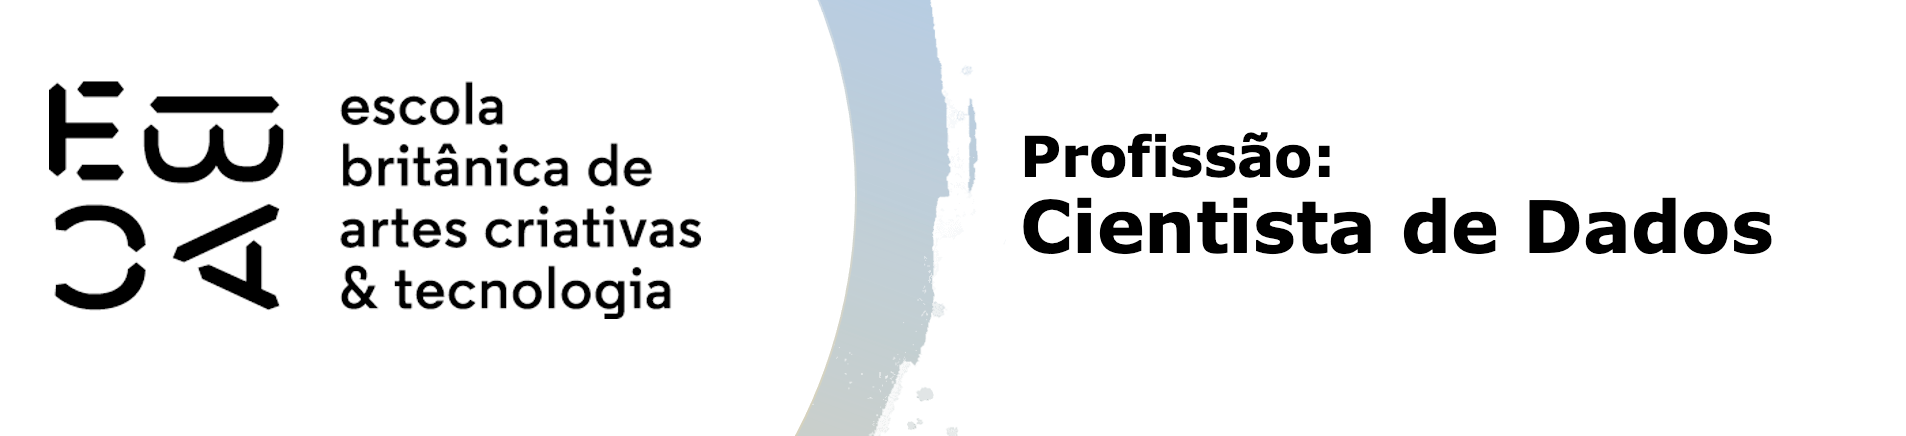

In [97]:
import pandas as pd
import seaborn as sns
import numpy as np


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [98]:
# carregando dados

df_original = pd.read_feather('credit_scoring.ftr')

# Sortear amostra de 10.000 registros (com reposição=False | para não repetir linhas)
df = df_original.sample(n=10_000, random_state=42)

df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
404846,2015-09-01,6593,F,N,S,0,Pensionista,Médio,Casado,Casa,62,NaN,2.0,5466.64,False
580313,2015-12-01,1403,F,N,S,0,Pensionista,Médio,Casado,Casa,58,NaN,2.0,6235.48,False
552086,2015-12-01,11876,F,S,N,0,Assalariado,Médio,Casado,Casa,30,1.991781,2.0,1588.68,False
370876,2015-08-01,13388,M,S,N,1,Empresário,Superior completo,Casado,Governamental,42,2.432877,3.0,12398.49,False
239330,2015-05-01,4678,F,S,N,0,Servidor público,Médio,União,Casa,45,19.534247,2.0,101062.66,False


In [99]:
# colunas

print(df.columns.tolist())


['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau']


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [100]:
# função pipeline



# 1. Substituição de nulos - usando mediana para numéricos
class SubstituirNulos(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.median_ = {}
    
    def fit(self, X, y=None):
        for col in X.select_dtypes(include=np.number).columns:
            self.median_[col] = X[col].median()
        return self
    
    def transform(self, X):
        X = X.copy()
        for col, med in self.median_.items():
            X[col].fillna(med, inplace=True)
        return X

# 2. Remoção de outliers pelo método IQR (substituindo por limites)
class RemoverOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, k=1.5):
        self.k = k
        self.limits_ = {}
    
    def fit(self, X, y=None):
        for col in X.select_dtypes(include=np.number).columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inf = Q1 - self.k * IQR
            limite_sup = Q3 + self.k * IQR
            self.limits_[col] = (limite_inf, limite_sup)
        return self
    
    def transform(self, X):
        X = X.copy()
        for col, (lim_inf, lim_sup) in self.limits_.items():
            X[col] = np.where(X[col] < lim_inf, lim_inf, X[col])
            X[col] = np.where(X[col] > lim_sup, lim_sup, X[col])
        return X

# Variável categórica para dummy
categorical_feature = ['posse_de_veiculo']

# Colunas numéricas (ajuste conforme seu dataset)
num_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau']

# Pipeline para colunas numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SubstituirNulos()),
    ('outlier', RemoverOutliers()),
    ('scaler', StandardScaler())
])

# Pipeline para coluna categórica com parâmetro corrigido
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Combinando os preprocessamentos
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, categorical_feature)
])

# Pipeline completo com PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5, random_state=42))
])

# Exemplo de uso com o DataFrame 'df'
X = df[num_features + categorical_feature].copy()

X_transformed = pipeline.fit_transform(X)

print("Shape dos dados após pipeline + PCA:", X_transformed.shape)


Shape dos dados após pipeline + PCA: (10000, 5)


### Treinar um modelo de regressão logistica com o resultado

In [101]:


# 1. Separar variável alvo
y = df['mau']

# 2. Remover variáveis que não devem ser usadas como preditoras
X = df.drop(columns=['mau', 'index', 'data_ref'], errors='ignore')

# 3. Preencher valores ausentes (nulos)
X = X.fillna(X.median(numeric_only=True))  # só trata numéricas

# 4. Converter variáveis categóricas em dummies
X = pd.get_dummies(X, drop_first=True)

# 5. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 6. Treinar o modelo
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train, y_train)

# 7. Previsões
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

# 8. Métricas auxiliares
def ks_stat(y_true, y_scores):
    df_ks = pd.DataFrame({'y': y_true, 'score': y_scores})
    df_ks = df_ks.sort_values('score', ascending=False)
    df_ks['cum_event'] = (df_ks['y'] == 1).cumsum() / (df_ks['y'] == 1).sum()
    df_ks['cum_nonevent'] = (df_ks['y'] == 0).cumsum() / (df_ks['y'] == 0).sum()
    return max(abs(df_ks['cum_event'] - df_ks['cum_nonevent']))

def gini(y_true, y_scores):
    return 2 * roc_auc_score(y_true, y_scores) - 1

# 9. Avaliação
print("=== Métricas na base de Treinamento ===")
print("Acurácia:", round(accuracy_score(y_train, y_train_pred), 4))
print("AUC:", round(roc_auc_score(y_train, y_train_proba), 4))
print("KS:", round(ks_stat(y_train, y_train_proba), 4))
print("Gini:", round(gini(y_train, y_train_proba), 4))

print("\n=== Métricas na base de Teste ===")
print("Acurácia:", round(accuracy_score(y_test, y_test_pred), 4))
print("AUC:", round(roc_auc_score(y_test, y_test_proba), 4))
print("KS:", round(ks_stat(y_test, y_test_proba), 4))
print("Gini:", round(gini(y_test, y_test_proba), 4))



=== Métricas na base de Treinamento ===
Acurácia: 0.9166
AUC: 0.782
KS: 0.4461
Gini: 0.5641

=== Métricas na base de Teste ===
Acurácia: 0.9167
AUC: 0.7632
KS: 0.3967
Gini: 0.5264


### Salvar o pickle file do modelo treinado

In [102]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(model, open(nome_arquivo, 'wb'))

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [103]:
# carregando a base de dados

df = pd.read_feather('credit_scoring.ftr')

dataset = df.sample(10000)

In [104]:
# retirando colunas 

dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [105]:
# dados

data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (9500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (500, 13)


In [106]:
from pycaret.classification import *


In [107]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(9500, 13)"
4,Transformed data shape,"(9500, 30)"
5,Transformed train set shape,"(6650, 30)"
6,Transformed test set shape,"(2850, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,17.5%


In [108]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [109]:
# forçando a variável qnt de filhos como numérica

data.qtd_filhos = data.qtd_filhos.astype(float)

In [110]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(9500, 13)"
4,Transformed data shape,"(9500, 30)"
5,Transformed train set shape,"(6650, 30)"
6,Transformed test set shape,"(2850, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,17.5%


In [111]:
# comparando modelos

best_model = compare_models(fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9167,0.7634,0.0000,0.0000,0.0000,0.0000,0.0000,2.2010
ridge,Ridge Classifier,0.9167,0.6337,0.0000,0.0000,0.0000,0.0000,0.0000,0.1690
dummy,Dummy Classifier,0.9167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1260
lda,Linear Discriminant Analysis,0.9165,0.6337,0.0000,0.0000,0.0000,-0.0003,-0.0012,0.1270
ada,Ada Boost Classifier,0.9161,0.7733,0.0579,0.4664,0.1011,0.0850,0.1375,0.3260
gbc,Gradient Boosting Classifier,0.9138,0.7711,0.0434,0.3667,0.0772,0.0604,0.1013,0.6140
svm,SVM - Linear Kernel,0.9123,0.7814,0.0667,0.2131,0.0787,0.0650,0.0799,0.2400
lightgbm,Light Gradient Boosting Machine,0.9108,0.7401,0.0687,0.3333,0.1134,0.0874,0.1190,0.3140
knn,K Neighbors Classifier,0.9078,0.6483,0.0777,0.2902,0.1195,0.0892,0.1117,0.2870
rf,Random Forest Classifier,0.9039,0.6996,0.0523,0.1960,0.0816,0.0497,0.0618,0.5900


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [112]:
# print

print(best_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [113]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9083,0.7332,0.0545,0.2500,0.0896,0.0618,0.0823
1,0.9098,0.7324,0.0727,0.3077,0.1176,0.0888,0.1153
2,0.9083,0.7551,0.0727,0.2857,0.1159,0.0852,0.1081
3,0.9143,0.7690,0.1091,0.4286,0.1739,0.1452,0.1841
4,0.9098,0.7359,0.0545,0.2727,0.0909,0.0651,0.0895
5,0.9158,0.7425,0.0909,0.4545,0.1515,0.1275,0.1751
6,0.9158,0.7707,0.0893,0.5000,0.1515,0.1293,0.1850
7,0.9038,0.7153,0.0357,0.1667,0.0588,0.0300,0.0403
8,0.9083,0.6935,0.0357,0.2222,0.0615,0.0391,0.0582


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [114]:
# lightgbm Hyperparameter Tunning

lightgbm_tuned = tune_model(lightgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8962,0.6624,0.0364,0.1111,0.0548,0.0146,0.0172
1,0.8842,0.7145,0.0727,0.1333,0.0941,0.0380,0.0400
2,0.8917,0.6823,0.1273,0.2258,0.1628,0.1097,0.1149
3,0.9008,0.7286,0.1818,0.3226,0.2326,0.1839,0.1926
4,0.8917,0.6749,0.1636,0.2571,0.2000,0.1450,0.1493
5,0.9023,0.7289,0.1636,0.3214,0.2169,0.1706,0.1817
6,0.9083,0.7427,0.1964,0.4074,0.2651,0.2225,0.2394
7,0.8887,0.6755,0.1071,0.2000,0.1395,0.0858,0.0906
8,0.8917,0.6919,0.1250,0.2333,0.1628,0.1105,0.1167


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


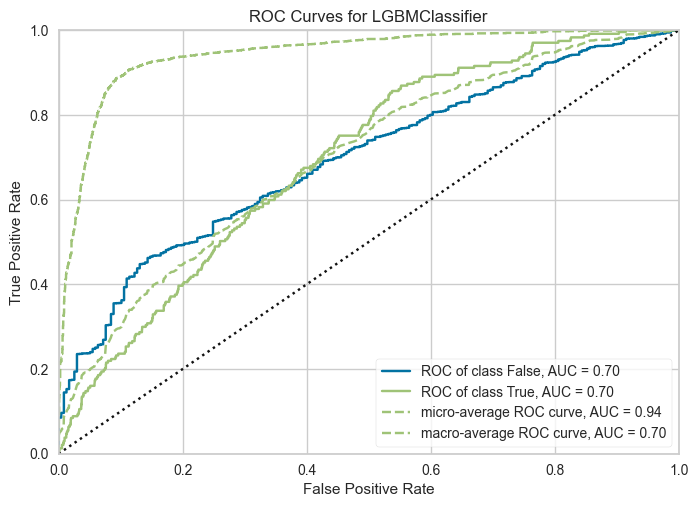

In [115]:
# AUC plot

plot_model(lightgbm_tuned, plot = 'auc')

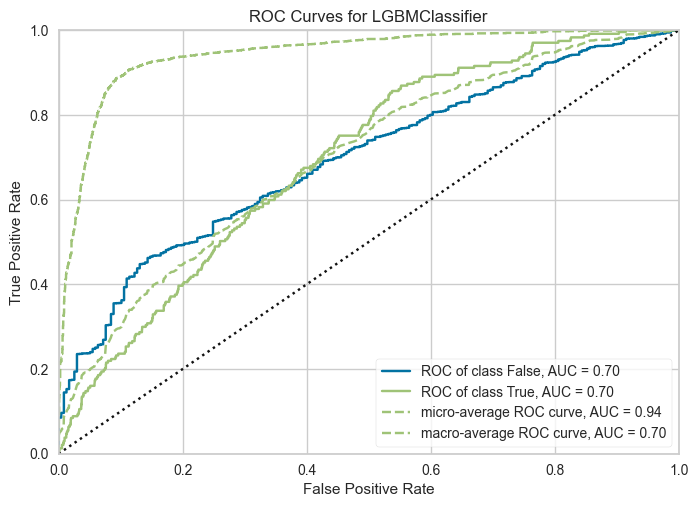

In [116]:
# AUC plot

plot_model(lightgbm_tuned, plot = 'auc')

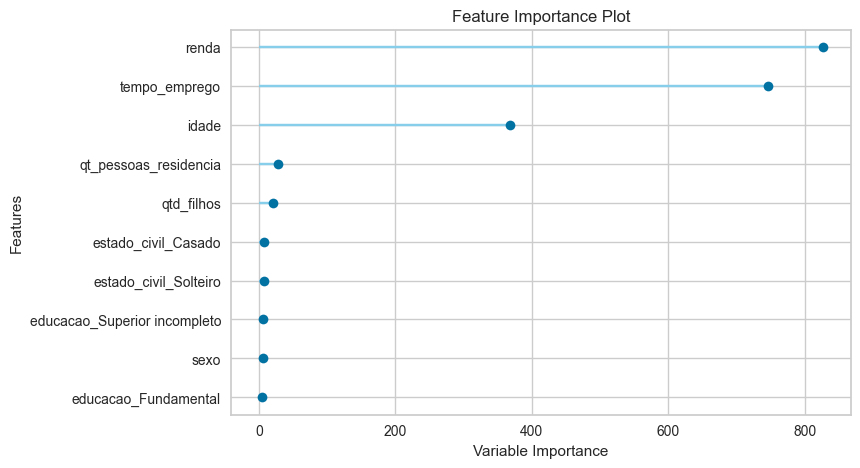

In [117]:
# Importância das variáveis (Feature Importance) Plot

plot_model(lightgbm_tuned, plot='feature')

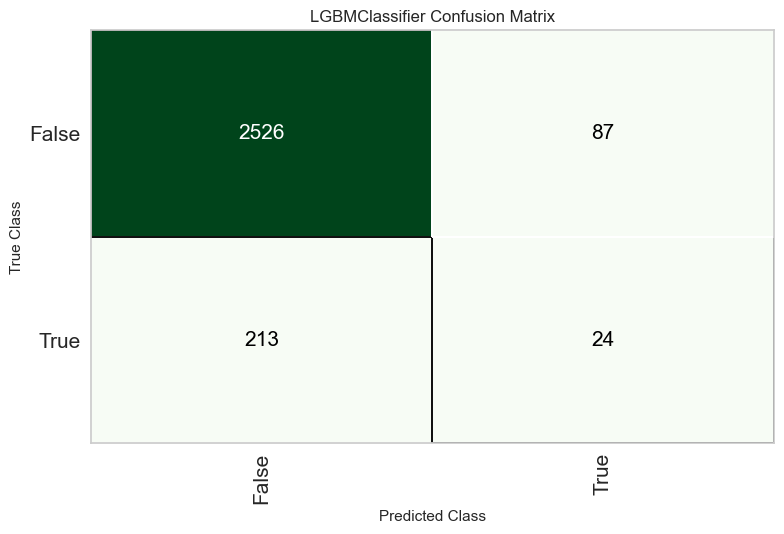

In [118]:
# Matriz de confusão (Confusion matrix)

plot_model(lightgbm_tuned, plot = 'confusion_matrix')

In [119]:
# Predict na amostra de validação / hold-out

predict_model(lightgbm_tuned);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8947,0.6964,0.1013,0.2162,0.1379,0.0896,0.0970


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [120]:
# Predict na amostra de validação / hold-out

predict_model(lightgbm_tuned);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8947,0.6964,0.1013,0.2162,0.1379,0.0896,0.0970


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [121]:
predict_model(lightgbm_tuned);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8947,0.6964,0.1013,0.2162,0.1379,0.0896,0.0970


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


### Salvar o arquivo do modelo treinado

In [122]:
# Salvando o modelo final

final_gbc = finalize_model(lightgbm_tuned)
print(final_gbc)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight=None,
                           

In [123]:
predict_model(lightgbm_tuned);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8947,0.6964,0.1013,0.2162,0.1379,0.0896,0.0970


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [124]:
# Predizendo o conjunto de dados que não foi usado no treino

unseen_predictions = predict_model(final_gbc, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9000,0.7961,0.1316,0.2273,0.1667,0.1175,0.1225


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,M,S,S,0,Pensionista,Superior completo,Casado,Casa,63,NaN,2.0,6858.919922,False,0,0.9948
1,F,S,N,0,Servidor público,Médio,União,Casa,45,19.534246,2.0,18198.919922,False,0,0.9961
2,F,N,N,0,Assalariado,Superior completo,Casado,Casa,26,3.665753,2.0,12222.940430,False,0,0.9967
3,F,S,S,0,Pensionista,Médio,Casado,Casa,66,NaN,2.0,7923.410156,False,0,0.9642
4,M,S,N,1,Assalariado,Superior completo,Casado,Casa,33,4.331507,3.0,3985.129883,False,0,0.9735


In [125]:
unseen_predictions.dtypes

sexo                     category
posse_de_veiculo         category
posse_de_imovel          category
qtd_filhos                   int8
tipo_renda               category
educacao                 category
estado_civil             category
tipo_residencia          category
idade                        int8
tempo_emprego             float32
qt_pessoas_residencia     float32
renda                     float32
mau                          bool
prediction_label            int32
prediction_score          float64
dtype: object

In [126]:
# Garante que a coluna target e predição estejam alinhadas

y_true = unseen_predictions['mau']
y_pred = unseen_predictions['prediction_label']

acc = accuracy_score(y_true, y_pred)
print(f"Acurácia: {acc:.4f}")

Acurácia: 0.9000


In [127]:
# Salvando o modelo final

save_model(final_gbc,'Final GBC Model 02Jun2022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            

In [128]:
# Carregando o modelo salvo

saved_final_gbc = load_model('Final GBC Model 02Jun2022')

Transformation Pipeline and Model Successfully Loaded


In [129]:
# nova predição

new_prediction = predict_model(saved_final_gbc, data=data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9000,0.7961,0.1316,0.2273,0.1667,0.1175,0.1225


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [130]:
# print

new_prediction.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,M,S,S,0,Pensionista,Superior completo,Casado,Casa,63,NaN,2.0,6858.919922,False,0,0.9948
1,F,S,N,0,Servidor público,Médio,União,Casa,45,19.534246,2.0,18198.919922,False,0,0.9961
2,F,N,N,0,Assalariado,Superior completo,Casado,Casa,26,3.665753,2.0,12222.940430,False,0,0.9967
3,F,S,S,0,Pensionista,Médio,Casado,Casa,66,NaN,2.0,7923.410156,False,0,0.9642
4,M,S,N,1,Assalariado,Superior completo,Casado,Casa,33,4.331507,3.0,3985.129883,False,0,0.9735


In [131]:
# Garante que a coluna target e predição estejam alinhadas

y_true = unseen_predictions['mau']
y_pred = unseen_predictions['prediction_label']

acc = accuracy_score(y_true, y_pred)
print(f"Acurácia: {acc:.4f}")

Acurácia: 0.9000


In [132]:
# nome dos passos

saved_final_gbc.named_steps

{'numerical_imputer': TransformerWrapper(exclude=None,
                    include=['qtd_filhos', 'idade', 'tempo_emprego',
                             'qt_pessoas_residencia', 'renda'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
                                              keep_empty_features=False,
                                              missing_values=nan,
                                              strategy='mean')),
 'categorical_imputer': TransformerWrapper(exclude=None,
                    include=['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                             'tipo_renda', 'educacao', 'estado_civil',
                             'tipo_residencia'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
                                              keep_empty_features=False,


# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.